In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean.cm
import xarray as xr
# fix to cartopy issue right now
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from cartopy.util import add_cyclic_point

In [4]:
# direc = '/tigress/GEOCLIM/janewb/MODEL_OUT'
# files = {}
# files['obs'] = '/tigress/janewb/HiTopo/etopo5.nc'
# files['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/zsurf.nc'
# files['cam'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/zsurf.nc'
# files['hitopo'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/zsurf.nc'
# files['cesm_ctrl'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_topo_mods/hose1Sv_ccsm4_pi01.cam2.h0.0001-01.nc'
# files['cesm_cam'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_topo_mods/shf_heating_topo6.cam2.h0.0001-01.nc'

direc = '/tigress/janewb/public_html/HITOPO/'
files = {}
files['obs'] = direc+'obs.etopo5.zsurf.nc'
files['ctrl'] = direc+'flor.ctrl.zsurf.nc'
files['cam'] = direc+'flor.cam.zsurf.nc'
files['hitopo'] = direc+'flor.hitopo.zsurf.nc'
files['cesm_ctrl'] = direc+'ccsm4.ctrl.land.nc'
files['cesm_cam'] = direc+'ccsm4.ideal_cam.land.nc'

data = {}
for key in files.keys():
    data[key] = xr.open_dataset(files[key])
    
for key in ['ctrl','cam','hitopo']:
    data[key] = data[key].rename({'GRID_XT':'lon','GRID_YT':'lat','ZSURF':'zsurf'})

for key in ['cesm_ctrl','cesm_cam']:
    data[key] = data[key].rename({'PHIS':'zsurf'})

data['obs'] = data['obs'].rename({'ETOPO05_X':'lon','ETOPO05_Y':'lat','ROSE':'zsurf'})

for key in files.keys():
    data[key] = data[key].roll(lon = -int(len(data[key].lon)/2), roll_coords = True) #change from 0-360 to 180-360 then 0 to 180
    data[key] = data[key].assign_coords(lon=(((data[key].lon + 180) % 360) - 180)) # change 180-360 to -180-0

maxz = {}
zsurf = {}
for key in files.keys():
    maxz[key] = np.squeeze(data[key].sel(lon=slice(240-360,285-360)).sel(lat=slice(-30,30)).max('lon').zsurf)
    zsurf[key] = np.squeeze(data[key].zsurf)

for key in ['cesm_ctrl','cesm_cam']:
    zsurf[key] = zsurf[key]/9.8
    maxz[key] = maxz[key]/9.8
 
diff = {}
diff['cesm'] = zsurf['cesm_cam'] - zsurf['cesm_ctrl']
diff['flor'] = zsurf['hitopo'] - zsurf['ctrl']
diff['flor_cam'] = zsurf['cam'] - zsurf['ctrl']


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:2147: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:745: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:746: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:747: RuntimeWarning: invalid value e

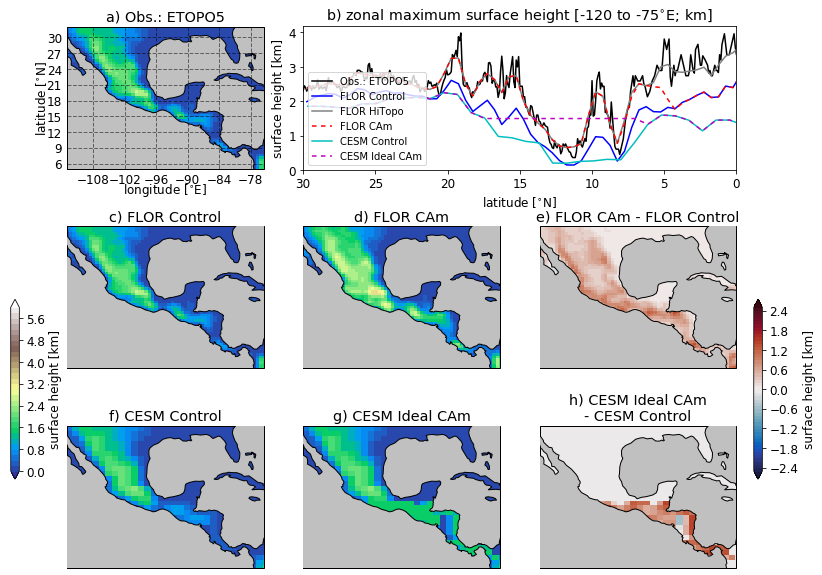

In [5]:
# CENTRAL AMERICA ONLY FIGURE

fig = plt.figure(constrained_layout=True, figsize=(12,10))
gs = fig.add_gridspec(3, 3)
fs = 12
plt.rcParams.update({'font.size': fs})

lev = np.arange(0,6.200,0.200)
lev2 = np.arange(-2.500,2.600,0.100)

proj1 = ccrs.PlateCarree(central_longitude = 0) #ccrs.Robinson()
cm1 = plt.cm.terrain
cm2 = cmocean.cm.balance

ax1 = fig.add_subplot(gs[0, 0], projection= proj1)
ax1.set_extent([247, 284.5, 5, 32], ccrs.PlateCarree())
im1 = (zsurf['ctrl']/1000).plot(transform=ccrs.PlateCarree(), extend = 'both', cmap = cm1, levels = lev, add_colorbar = False)
ax1.add_feature(feature.OCEAN, zorder=1, edgecolor='k', facecolor = 'silver')
plt.title('a) Obs.: ETOPO5')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax1.set_xlabel('longitude [$^{\circ}$E]')
ax1.set_ylabel('latitude [$^{\circ}$N]')

ax0 = fig.add_subplot(gs[0, 1:])
lats_o = maxz['obs'].lat
lats_m = maxz['ctrl'].lat
lats_mc = maxz['cesm_ctrl'].lat
plt.plot(lats_o, maxz['obs']/1000,color='k',label='Obs.: ETOPO5')
plt.plot(lats_m, maxz['ctrl']/1000,color='b',label='FLOR Control')
plt.plot(lats_m, maxz['hitopo']/1000,color='grey',label='FLOR HiTopo')
plt.plot(lats_m, maxz['cam']/1000,color='r',dashes=[3,3,3,3],label='FLOR CAm')
plt.plot(lats_mc, maxz['cesm_ctrl']/1000,color='c', label='CESM Control')
plt.plot(lats_mc, maxz['cesm_cam']/1000,color='m',dashes=[3,3,3,3], label='CESM Ideal CAm')
plt.ylabel('surface height [km]')
plt.xlabel('latitude [$^{\circ}$N]')
plt.legend(fontsize=10,loc='lower left')
plt.title('b) zonal maximum surface height [-120 to -75$^{\circ}$E; km]')
ax0.set_xlim(30, 0)
ax0.set_ylim([0, 4.2])
#ax0.axvline(16.724,color='orange') # Chivela Pass
#ax0.axvline(10.7,color='orange') # Papagayo
#ax0.axvline(7.9,color='orange') # Panama
#ax0.yaxis.set_label_position("right")
#ax0.yaxis.tick_right()

ax2 = fig.add_subplot(gs[1, 0], projection= proj1)
ax2.set_extent([247, 284.5, 5, 32], ccrs.PlateCarree())
(zsurf['ctrl']/1000).plot(transform=ccrs.PlateCarree(), cmap = cm1, extend = 'both', levels = lev, add_colorbar=False)
ax2.add_feature(feature.OCEAN, zorder=100, edgecolor='k', facecolor = 'silver')
plt.title('c) FLOR Control')

ax3 = fig.add_subplot(gs[2, 0], projection= proj1)
ax3.set_extent([247, 284.5, 5, 32], ccrs.PlateCarree())
(zsurf['cesm_ctrl']/1000).plot(transform=ccrs.PlateCarree(), cmap = cm1, extend = 'both', levels = lev, add_colorbar=False)
ax3.add_feature(feature.OCEAN, zorder=100, edgecolor='k', facecolor = 'silver')
plt.title('f) CESM Control')

#ax4 = blank

ax5 = fig.add_subplot(gs[1, 1], projection= proj1)
ax5.set_extent([247, 284.5, 5, 32], ccrs.PlateCarree())
(zsurf['cam']/1000).plot(transform=ccrs.PlateCarree(), cmap = cm1, extend = 'both', levels = lev, add_colorbar=False)
ax5.add_feature(feature.OCEAN, zorder=100, edgecolor='k', facecolor = 'silver')
plt.title('d) FLOR CAm')

ax6 = fig.add_subplot(gs[2, 1], projection= proj1)
ax6.set_extent([247, 284.5, 5, 32], ccrs.PlateCarree())
(zsurf['cesm_cam']/1000).plot(transform=ccrs.PlateCarree(), cmap = cm1, extend = 'both', levels = lev, add_colorbar=False)
ax6.add_feature(feature.OCEAN, zorder=100, edgecolor='k', facecolor = 'silver')
plt.title('g) CESM Ideal CAm')

#ax7=blank

ax8 = fig.add_subplot(gs[1, 2], projection= proj1)
ax8.set_extent([247, 284.5, 5, 32], ccrs.PlateCarree())
im2 = (diff['flor']/1000).plot(transform=ccrs.PlateCarree(), cmap = cm2, extend = 'both', levels = lev2, add_colorbar=False)
ax8.add_feature(feature.OCEAN, zorder=100, edgecolor='k', facecolor = 'silver')
plt.title('e) FLOR CAm - FLOR Control')

ax9 = fig.add_subplot(gs[2, 2], projection= proj1)
ax9.set_extent([247, 284.5, 5, 32], ccrs.PlateCarree())
(diff['cesm']/1000).plot(transform=ccrs.PlateCarree(), cmap = cm2, extend = 'both', levels = lev2, add_colorbar=False)
ax9.add_feature(feature.OCEAN, zorder=100, edgecolor='k', facecolor = 'silver')
plt.title('h) CESM Ideal CAm\n- CESM Control')

fig.subplots_adjust(wspace=0.2, hspace = 0.38)
cb1_ax = fig.add_axes([0.06, 0.25, 0.01, 0.25])
cb1 = fig.colorbar(im1, cax=cb1_ax, orientation = 'vertical')
cb1.ax.set_ylabel('surface height [km]')

cb2_ax = fig.add_axes([0.92, 0.25, 0.01, 0.25])
cb2 = fig.colorbar(im2, cax=cb2_ax, orientation = 'vertical')
cb2.ax.set_ylabel('surface height [km]')

t1 = ax1.text(0.5,-0.15,'longitude [$^{\circ}$E]',fontsize=fs, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
t1b = ax1.text(-0.13,0.5,'latitude [$^{\circ}$N]',fontsize=fs, horizontalalignment='center', verticalalignment='center', rotation = 90, transform=ax1.transAxes)

#plt.savefig('bc_cam.png',dpi=600)
#plt.savefig('bc.pdf')

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:745: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:746: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:747: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:748: RuntimeWarning: invalid value encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)


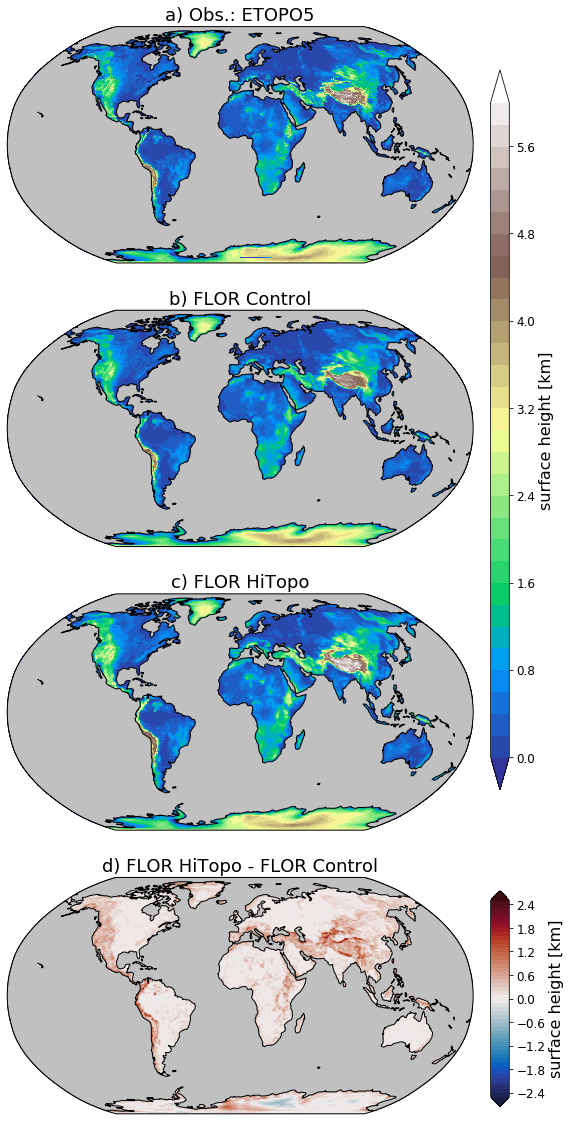

In [6]:
# FLOR FIGURE GLOBAL

lev = np.arange(0,6.200,0.200)
lev2 = np.arange(-2.500,2.600,0.100)

proj1 = ccrs.Robinson(central_longitude = 0) #ccrs.Robinson()
cm1 = plt.cm.terrain
cm2 = cmocean.cm.balance

fig = plt.figure(figsize=(13,20))

ax1 = plt.subplot(4,1,1,projection=proj1)
ax1.set_extent([zsurf['obs'].lon.min(), zsurf['obs'].lon.max(), -90, 90], ccrs.PlateCarree())
im1 = (zsurf['obs']/1000).plot(transform=ccrs.PlateCarree(), cmap = cm1, extend = 'both', levels = lev, add_colorbar=False)
ax1.add_feature(feature.OCEAN, zorder=100, edgecolor='k', facecolor = 'silver')
plt.title('a) Obs.: ETOPO5', fontsize = 18)

ax3 = plt.subplot(4,1,2,projection=proj1)
(zsurf['ctrl']/1000).plot(transform=ccrs.PlateCarree(), cmap = cm1, extend = 'both', levels = lev, add_colorbar=False)
ax3.add_feature(feature.OCEAN, zorder=100, edgecolor='k', facecolor = 'silver')
plt.title('b) FLOR Control', fontsize = 18)

ax5 = plt.subplot(4,1,3,projection=proj1)
(zsurf['hitopo']/1000).plot(transform=ccrs.PlateCarree(), cmap = cm1, extend = 'both', levels = lev, add_colorbar=False)
ax5.add_feature(feature.OCEAN, zorder=100, edgecolor='k', facecolor = 'silver')
plt.title('c) FLOR HiTopo', fontsize = 18)

ax7 = plt.subplot(4,1,4,projection=proj1)
im2 = (diff['flor']/1000).plot(transform=ccrs.PlateCarree(), cmap = cm2, extend = 'both', levels = lev2, add_colorbar=False)
ax7.add_feature(feature.OCEAN, zorder=100, edgecolor='k', facecolor = 'silver')
plt.title('d) FLOR HiTopo - FLOR Control', fontsize = 18)

fig.subplots_adjust(right=1)
cb1_ax = fig.add_axes([0.83, 0.35, 0.02, 0.5])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('surface height [km]', rotation=90, fontsize=16)

cb2_ax = fig.add_axes([0.83, 0.13, 0.02, 0.15])
cb2 = fig.colorbar(im2, cax=cb2_ax)
cb2.ax.set_ylabel('surface height [km]', rotation=90, fontsize=16)

#plt.tight_layout()
#plt.savefig('bc_flor_global.png', dpi = 600)

plt.show()